# Convolutional Neural Networks - Solutions

<hr style="clear:both">

This notebook is part of a series of exercises for the CIVIL-226 Introduction to Machine Learning for Engineers course at EPFL. Copyright (c) 2022 [VITA](https://www.epfl.ch/labs/vita/) lab at EPFL  
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** [David Mizrahi](mailto:david.mizrahi@epfl.ch)

**2022 TAs:** [Brian Sifringer](mailto:brian.sifringer@epfl.ch), [Bastien Van Delft](mailto:bastien.vandelft@epfl.ch), [Taylor Mordan](mailto:taylor.mordan@epfl.ch), [Victor Dubien](mailto:victor.dubien@epfl.ch), [David Mizrahi](mailto:david.mizrahi@epfl.ch)

<hr style="clear:both">



In this exercise, we'll build on what was done in the previous exercise and implement Convolutional Neural Nets with PyTorch.

*Run next cell to show tweet*

In [1]:
%%html
<blockquote class="twitter-tweet" data-lang="en" data-dnt="true"><p lang="en" dir="ltr">A demo from 1993 of 32-year-old Yann LeCun showing off the world&#39;s first convolutional network for text recognition. <a href="https://twitter.com/hashtag/tbt?src=hash&amp;ref_src=twsrc%5Etfw">#tbt</a> <a href="https://twitter.com/hashtag/ML?src=hash&amp;ref_src=twsrc%5Etfw">#ML</a> <a href="https://twitter.com/hashtag/neuralnetworks?src=hash&amp;ref_src=twsrc%5Etfw">#neuralnetworks</a> <a href="https://twitter.com/hashtag/CNNs?src=hash&amp;ref_src=twsrc%5Etfw">#CNNs</a> <a href="https://twitter.com/hashtag/MachineLearning?src=hash&amp;ref_src=twsrc%5Etfw">#MachineLearning</a> <a href="https://t.co/9eeibjJ4MK">pic.twitter.com/9eeibjJ4MK</a></p>&mdash; MIT CSAIL #AAAI2021 (@MIT_CSAIL) <a href="https://twitter.com/MIT_CSAIL/status/1347237563342340097?ref_src=twsrc%5Etfw">January 7, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

Before we get started, you'll need to install the [`torchsummary` package](https://github.com/sksq96/pytorch-summary) for a specific section of the exercise.
You can do so directly from the command line with:
```
pip install torchsummary
```
Make sure that you are in the correct conda environment before running that command.

#### For Google Colab
You can run this notebook in Google Colab using the following link: https://colab.research.google.com/github/vita-epfl/introML-2022/blob/main/exercises/07-convnets/convnets_Sol.ipynb

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    # Install torchsummary
    !pip install torchsummary
    # Clone the entire repo to access the files
    !git clone -l -s https://github.com/vita-epfl/introML-2022.git cloned-repo
    %cd cloned-repo/exercises/07-convnets/

## 1. Imports & set-up

This part is nearly identical to last week's exercise on fully-connected neural networks.

More specifically, we define:

- the MNIST dataset & dataloader
- the training & test loop
- a 3-layer fully connected neural net (now called `three_layer_net` instead of `model`)

Then this neural net is trained for 10 epochs. This time, we use **Adam instead of SGD** as our optimizer.

In [3]:
# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST

# torchsummary
import torchsummary

# Progress bar
from tqdm.auto import tqdm

# Helper files
import helpers
import metrics

In [4]:
torch.__version__

'1.8.0'

In [5]:
torchvision.__version__

'0.9.0a0'

As was done last exercise, here is a brief description of these imported packages:

**PyTorch:**
- `torch.nn` Contains the basic building blocks to implement neural nets (incl. different types of layers and loss functions) | [Documentation](https://pytorch.org/docs/stable/nn.html)
- `torch.nn.functional` A functional (stateless) approach to torch.nn, often used for stateless objects (e.g. ReLU) | [Documentation](https://pytorch.org/docs/stable/nn.functional.html) | [More info](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/2)
- `torch.optim` A package implementing various optimization algorithms, such as SGD and Adam | [Documentation](https://pytorch.org/docs/stable/optim.html)

**torchvision:**
- `torchvision.transforms` Common image transformations
- `torchvision.datasets` Popular image datasets

**`torchsummary`:** Provides additional information on network architecture

**`tqdm`:** Popular package used to show progress bars | [Documentation](https://tqdm.github.io/)

**`helpers`**: Contains functions to help visualize data and predictions

**`metrics`:** Contains two simple classes that help keep track and compute the loss and accuracy over a training epoch

### Dataset & dataloader

In [6]:
# Save dataset in a folder called "/data"
root = "data"

# transforms.ToTensor() is used to convert the downloaded PIL Image to a torch Tensor
train_data = MNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_data = MNIST(root, train=False, transform=transforms.ToTensor(), download=True)

batch_size = 32
# Reshuffle training data at every epoch, but not the test data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
print(f"Images in training data: {len(train_data)}")
print(f"Images in test data: {len(test_data)}")
# Show the mapping from target value to class name (if you're using MNIST, you won't be too surprised)
print("Mapping from targer value to class name:")
{i: class_name for i, class_name in enumerate(train_data.classes)}

Images in training data: 60000
Images in test data: 10000
Mapping from targer value to class name:


{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

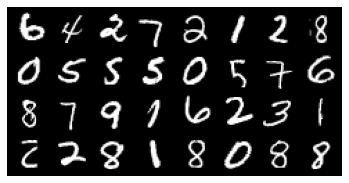

tensor([[6, 4, 2, 7, 2, 1, 2, 8],
        [0, 5, 5, 5, 0, 5, 7, 6],
        [8, 7, 9, 1, 6, 2, 3, 1],
        [2, 2, 8, 1, 8, 0, 8, 8]])


In [8]:
images, targets = iter(train_loader).next()
helpers.imshow(torchvision.utils.make_grid(images, nrow=8))
print(targets.reshape(-1, 8))

### Training loop & test accuracy

In [9]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    
    # Initialize metrics for loss and accuracy
    loss_metric = metrics.LossMetric()
    acc_metric = metrics.AccuracyMetric(k=1)
    
    model.train()
    
    for epoch in range(1, epochs + 1):
        
        # Progress bar set-up
        pbar = tqdm(total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
        
        # Iterate through data
        for data, target in train_loader:
            
            # Zero-out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data)
            
            # Compute loss
            loss = loss_fn(out, target)
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()

            # Update metrics & progress bar
            loss_metric.update(loss.item(), data.shape[0])
            acc_metric.update(out, target)
            pbar.update()
            
        # End of epoch, show loss and acc
        pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f} | Train acc: {acc_metric.compute() * 100:.2f}%")
        loss_metric.reset()
        acc_metric.reset()
        
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    
    # Initialize accuracy metric
    acc_metric = metrics.AccuracyMetric(k=1)
    
    # Progress bar set-up
    pbar = tqdm(total=len(test_loader), leave=True)
    
    model.eval()
    
    with torch.no_grad(): 
        # Iterate through data
        for data, target in dataloader:
            
            # Forward pass
            out = model(data)
            
            # Update accuracy metric
            acc_metric.update(out, target)

            # Update progress bar
            pbar.update()
            
    # End of epoch, show loss and acc
    test_acc = acc_metric.compute() * 100
    pbar.set_postfix_str(f"Acc: {test_acc:.2f}%")
    print(f"Accuracy is {test_acc:.2f}%")

### Three layer fully-connected NN

In [10]:
class ThreeLayerNet(nn.Module):
    """3-Layer neural net"""
    
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten to get tensor of shape (batch_size, 784)
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

# Note: Instance is called three_layer_net instead of model this time around
three_layer_net = ThreeLayerNet()

#### Loss & optimizer

As before, we'll use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss.

However, this time, we'll switch up optimizers and use **[Adam](https://pytorch.org/docs/master/generated/torch.optim.Adam.html)** with the default settings for the learning rate and momentum. This should help us get faster convergence than with SGD.

Implement both the loss and the optimizer in the next cell.

In [11]:
### START CODE HERE ###
# Cross-Entropy loss
loss_fn = nn.CrossEntropyLoss()
# Use Adam with default parameters
optimizer = optim.Adam(three_layer_net.parameters())
### END CODE HERE ###

####  Training

In [12]:
train(three_layer_net, train_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [13]:
test(three_layer_net, test_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 97.71%


**Expected result:** >96% test accuracy on MNIST

## 2. LeNet

In this part, you'll implement a slightly modified version of LeNet5, a convolutional neural network proposed by [Yann Le Cun et al. in 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). LeNet was one of the earliest convolutional neural networks, and helped promote the development of deep learning. Your goal is to reproduce this network architecture from just the paper's figure (see below) and a few extra tips.

#### LeNet5

<img src="images/lenet.png" width=900></img>

Here are some tips to help you with your implementation:

- Our images are 28x28, but the figure shows 32x32 input images. Can you find a way to make our images fit? **Hint:**  `nn.Conv2d` has a padding parameter.
- Both convolutional layers use 5x5 filters with stride 1
- Use ReLU as your activation function
- Ue Max-Pooling whenever subsampling is needed
- You'll need to flatten your tensor at some point
- No need to add softmax after the final layer, `nn.CrossEntropyLoss()` adds it automatically

Furthermore, here is some helpful documentation:
- [`torch.nn` documentation](https://pytorch.org/docs/stable/nn.html)
- [`torch.nn.functional` documentation](https://pytorch.org/docs/stable/nn.functional.html)

In [14]:
class LeNet(nn.Module):
    """LeNet5 from `"Gradient-Based Learning Applied To Document Recognition"
    <http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf>`_
    """
    
    ### YOUR CODE HERE ### (Define __init__() and forward())

    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out
    
    ### END CODE HERE ###
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)


lenet = LeNet()

In [15]:
# Check that a forward pass gives the correct output size
print(lenet(images).shape)

torch.Size([32, 10])


**Expected output:** `torch.Size([32, 10])`

In [16]:
### START CODE HERE ###
# Cross-Entropy loss
loss_fn = nn.CrossEntropyLoss()
# Adam
optimizer = optim.Adam(lenet.parameters())
### END CODE HERE ###

####  Training

In [17]:
train(lenet, train_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [18]:
test(lenet, test_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 99.03%


**Expected result:** >98% test accuracy on MNIST

#### Visualizing predictions

Let's visualize some of these predictions with the help of `view_prediction()` from `helpers`.

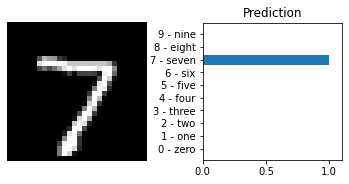

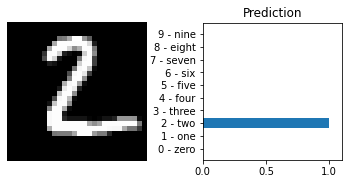

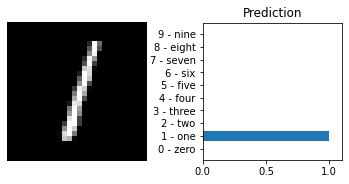

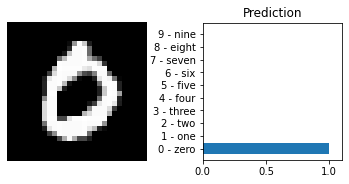

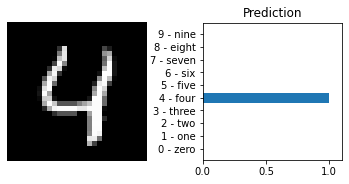

In [19]:
images, _ = iter(test_loader).next()
preds = lenet.predict(images)

# Shows the image next to the classifier's softmax score
# Show for the first 5 images (change value to see more images)
for i in range(5):
    helpers.view_prediction(images[i], preds[i], test_data.classes)

## 3. Comparing networks

We've successfully trained two models on the MNIST dataset. But how do they differ? To find out, we'll compare their test accuracy and their architecture.

#### Test accuracy

In [20]:
print("3-layer fully-connected net test accuracy:")
test(three_layer_net, test_loader)

3-layer fully-connected net test accuracy:


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 97.71%


In [21]:
print("LeNet-5 test accuracy")
test(lenet, test_loader)

LeNet-5 test accuracy


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 99.03%


#### Model size

In [22]:
torchsummary.summary(three_layer_net, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                  [-1, 100]          10,100
            Linear-3                   [-1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [23]:
torchsummary.summary(lenet, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


**Questions:** 
- Which model has the highest accuracy?
- Compare the number of trainable parameters (weights) in both networks? Where do most of LeNet's trainable parameters come from?
- Which model takes longer to train? Look at the `it/s` metric displayed next to the progress bar.

**Answers:** 
- LeNet performs slightly better, as it reaches ~99% accuracy on MNIST, while the 3-layer FC net gets ~97% accuracy.
- Despite performing better, LeNet has slightly less trainable parameters than the 3 layer network. Also, notice that most of LeNet's weights come from the linear layers.
- On CPU, LeNet takes longer to train (about 2x longer on our device). 

## 4. Mixing it up

LeNet performs quite well on MNIST. But what would happen if we apply a fixed random permutation to the pixels of the images?

To find out, we'll create a dataset we'll call permuted MNIST. It simply takes the original dataset, and permutes pixels before feeding images to the network.

### Permuted MNIST

In [24]:
# Fix random seed so permutation is identical across runs
torch.manual_seed(42)
perm_indices = torch.randperm(784)
# Set back to random seed
torch.random.seed()

# The same permutation gets applied to each image 
permute_transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten()[perm_indices].reshape(1, 28, 28))])

In [25]:
permuted_train_data = MNIST(root, train=True, transform=permute_transform, download=True)
permuted_test_data = MNIST(root, train=False, transform=permute_transform, download=True)

batch_size = 32
permuted_train_loader = torch.utils.data.DataLoader(permuted_train_data, batch_size=batch_size, shuffle=True)
permuted_test_loader = torch.utils.data.DataLoader(permuted_test_data, batch_size=batch_size, shuffle=False)

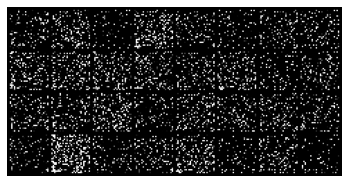

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


In [26]:
# Visualize permuted images
permuted_images, targets = iter(permuted_test_loader).next()
helpers.imshow(torchvision.utils.make_grid(permuted_images, nrow=8))
print(targets.reshape(-1, 8))

Pretty hard for us humans to tell which digit is which, right?

**Question:** Before starting the training process, how do you think this random permutation will affect the performance of the two networks (3-layer net and LeNet)?

**Answer:** 

3-layer net is a fully connected neural net, which doesn't make any assumptions regarding the structure of our data. Therefore, it should be completely unaffected by the permutation (and the images gets flattened beforehand anyway).

LeNet is a convolutional neural network which makes the explicit assumption that input are images (e.g. weight sharing, kernels & pooling layers only take into account neighboring parts of the images, etc...) so we should expect the accuracy to drop when permuting pixels, as the images lose their structure.


### Training on permuted images

Let's now train our two network architectures on this permuted dataset. As only the dataset changes, the training procedure will be almost exactly the same as previously.

#### Fully-connected NN (3-layer net)

In [27]:
permuted_three_layer_net = ThreeLayerNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(permuted_three_layer_net.parameters())

train(permuted_three_layer_net, permuted_train_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [28]:
test(permuted_three_layer_net, permuted_test_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 96.96%


#### LeNet

In [29]:
permuted_lenet = LeNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(permuted_lenet.parameters())

train(permuted_lenet, permuted_train_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [30]:
test(permuted_lenet, permuted_test_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 95.79%


Our 3 layer net is completely unaffected by the permutation, while the accuracy of LeNet decreases.

This is to be expected. A ConvNet makes the explicit assumption that the input are images, which allows it to encode certain properties into the architecture, while a fully-connected neural net makes no assumption of the sort. When these assumptions hold, a ConvNet performs quite well but suffers otherwise. Note that LeNet still performs quite well, in part thanks to the final few fully-connected layers, and because MNIST is a particularly easy dataset, where [most digits can be distinguished pretty well with just one pixel](https://gist.github.com/dgrtwo/aaef94ecc6a60cd50322c0054cc04478). 

As real-world images don't have all their pixels permuted by a malicious exercise maker, you can safely use ConvNets for most tasks involving images.

Congratulations on finishing this exercise!

## Additional PyTorch resources
- PyTorch basics: https://pytorch.org/tutorials/beginner/basics/intro.html
- PyTorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html
- Other PyTorch tutorials: https://pytorch.org/tutorials/index.html
- PyTorch recipes: https://pytorch.org/tutorials/recipes/recipes_index.html (bite-sized code examples on specific PyTorch features)
- PyTorch examples: https://github.com/pytorch/examples